# Training

This notebook demonstrates the process of training an ensemble learning model using a provided CSV file. It showcases data preprocessing, model training, evaluation, and saving the trained model. The ensemble method (hard voting, soft voting, or stacking) can be selected based on the user's choice.


## Importing Necessary Libraries

First, we import all the necessary libraries and modules needed for this script. This includes libraries for handling warnings, data manipulation, machine learning, and the custom Ensemble module containing ensemble learning methods.

In [1]:
import pandas as pd
import os
import math
import numpy as np
from src import Utils, Bayes

import sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, tokenized_text, TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt 
import joblib

pd.set_option('max_colwidth', 800)

/tmp/ipykernel_30469/1069041386.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Settings

In [2]:
TEST_SIZE = 0.2

SAVE_MODEL = False
MODEL_FOLDER = 'models/model_bayes/sample-6'
DATASET = 'datasets/datasetall.csv'

LOWERCASE_TEXT = True
REMOVE_PUNCTUATION = True
REMOVE_STOPWORDS = True


## Utility Functions

### Model saving folder creation

Create a folder to save the model based on `MODEL_FOLDER`

In [3]:
if SAVE_MODEL:
  os.makedirs(
    MODEL_FOLDER,
    exist_ok=True, # Create folder if it doesn't exist, else do nothing
  )

  print(f"Saving model at '{MODEL_FOLDER}'")

### Function to Read CSV File

The `read_csv_file` function reads the CSV file and returns a pandas DataFrame. If the file is not found, the script will exit with an error message.

In [4]:
def read_csv_file(filename: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(filename, lineterminator='\n', usecols=range(2))
        print("CSV file read successfully!")
        return data
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

dataset = read_csv_file(DATASET)
dataset

CSV file read successfully!


,text,label
0,Binay: Patuloy ang kahirapan dahil sa maling pamamahala [USERNAME],0
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT! Kulay Rosas Ang Bukas Let Leni Kiko Lead Let Leni Lead panalo Natin Para Sa Lahat : [USERNAME],0
2,wait so ur telling me Let Leni Lead mo pero NYONG UYAB BBM SUPPORTER?!??!!!????? to me thats like dating a trump supporter. fuck no bye,1
3,[USERNAME]wish this is just a nightmare that could end. Ma Pa we failed again. let leni lead never again kakampink Sa Gobyernong Tapat Angat Buhay Lahat,0
4,doc willie ong and isko sabunutan po,0
...,...,...
28456,"Bisaya, Probinsyano/a, mostly Bisaya = katulong",1
28457,Amnesia. In my whole life wala pa ako nakasalamuha na nagkaamnesia. Sa telenovela akala mo sipon lang yung amnesia. Nag-maynila yung lead actress. Naging pokpok. Or napasama sa human trafficking eme eme. Baril. Aside sa security guards madalang ako makakita nito. Pero sa telenovela akala mo nabibili sa sari sari store yung baril sa sobrang common. Deadbeat dad and abusive step father. Puta lagi na lang ganito yung cannon event ng bida. Di ba pwedeng normal lang na buhay?,1
28458,Kontrabida na ilang beses na tinalo at obvious naghihirap pero somehow may resource para maghire ng goons and sht... Like btch how are you paying for all these schemes???,1
28459,Yung antagonist laging kailangang sobrang sama. Lalong lalo na sa mga GMA soap. Yung tipong romance tapos sa dulo magiging parang action dahil yung kontrabida may papatayin or i hostage. Ayun kabwiset.,1


In [5]:
dataset['label'].value_counts(ascending=True)

label
0    14115
1    14346
Name: count, dtype: int64

### Function for Train-Test Split

The `get_train_test_split` function splits the dataset into training and testing sets with an 80-20 split ratio and returns them.

In [6]:
random_number_generator = np.random.default_rng(seed=0)
def shuffle_data_frame(data_frame):
    text = list(data_frame['text'])
    label = list(data_frame['label'])

    assert(len(text) == len(label))

    indices = list(range(len(label)))

    # Make a random number generator that will shuffle list of indices
    # It is seeded to be reproducible
    random_number_generator.shuffle(indices)

    shuffled_text = []
    shuffled_labels = []

    # Iterate through the list of indices and add the original data
    # from those shuffled indices
    for index in indices:
        shuffled_text.append(text[index])
        shuffled_labels.append(label[index])

    return pd.DataFrame({
        'text': shuffled_text,
        'label': shuffled_labels,
    })


def get_train_test_split(data_frame: pd.DataFrame, test_size: float):
    """
    Makes a stratified train test split.
    This aims to preserve the distribution between classes.
    """
    if not (1 > test_size > 0):
        print('ERROR: test_size must be between 0 and 1')
        return

    data_frame = shuffle_data_frame(data_frame)

    data_frame_length = len(data_frame)
    train_size = 1 - test_size

    nonhate_rows = data_frame[data_frame['label'] == 0] 
    nonhate_row_length = len(nonhate_rows)

    nonhate_row_train_size = math.ceil(nonhate_row_length * train_size)

    nonhate_row_train = nonhate_rows[0:nonhate_row_train_size]
    nonhate_row_test = nonhate_rows[nonhate_row_train_size:nonhate_row_length]

    assert(len(nonhate_row_train) + len(nonhate_row_test) == nonhate_row_length)

    hate_rows = data_frame[data_frame['label'] == 1] 
    hate_row_length = len(hate_rows)

    hate_row_train_size = math.ceil(hate_row_length * train_size)

    hate_row_train = hate_rows[0:hate_row_train_size]
    hate_row_test = hate_rows[hate_row_train_size:hate_row_length]

    assert(len(hate_row_train) + len(hate_row_test) == hate_row_length)

    combined_train = pd.concat([nonhate_row_train, hate_row_train])
    combined_test = pd.concat([nonhate_row_test, hate_row_test])

    shuffled_train = shuffle_data_frame(combined_train)
    shuffled_test = shuffle_data_frame(combined_test)

    return (
        shuffled_train['text'],
        shuffled_test['text'],
        shuffled_train['label'],
        shuffled_test['label'],
    )

## Process Data

In [7]:
import re
from collections import Counter

def data_to_lower(data):
  return [text.lower() for text in data]

def data_remove_punctuation(data):
  # Pattern to match nonwords and nonwhitespace
  return [re.sub(r'[^\w\s]', '', text) for text in data]

def data_remove_stopwords(data):
  stopwords_list = open(
    './src/stopwords-tl.txt',
    'r',
  ).read().split('\n')
  stopwords_dict = Counter(stopwords_list)
  return [
    ' '.join([
      word for word in sample.split()
      if word not in stopwords_dict
    ])
    for sample 
    in data
  ]

In [8]:
pd.DataFrame(dataset['text'][:30])

,text
0,Binay: Patuloy ang kahirapan dahil sa maling pamamahala [USERNAME]
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT! Kulay Rosas Ang Bukas Let Leni Kiko Lead Let Leni Lead panalo Natin Para Sa Lahat : [USERNAME]
2,wait so ur telling me Let Leni Lead mo pero NYONG UYAB BBM SUPPORTER?!??!!!????? to me thats like dating a trump supporter. fuck no bye
3,[USERNAME]wish this is just a nightmare that could end. Ma Pa we failed again. let leni lead never again kakampink Sa Gobyernong Tapat Angat Buhay Lahat
4,doc willie ong and isko sabunutan po
5,Jeonghan said Let Leni Lead!! Lenihae ahahhdjfj
6,[USERNAME] [USERNAME]and[USERNAME] Hahahhahaha SMNIpresidentialdebateLeni Mas Duwag
7,[USERNAME] Attendees of the CNNPHVPDebate are Walden Bello Rizalito David Manny SD Lopez Doc Willie Ong Kiko Pangilinan Carlos Serapio and Tito Sotto.| via[USERNAME]PTVElection TV
8,Abscbn News Hoaxnews ng abias cbend baklas poster ng mmda walang pinakita na tinatangal ang poster ni mar roxas whaaahhh biased talaga
9,NEWS UPDATE: The camp of VP Leni Robredo says it 'appreciates' the apology of ex-DND Sec. Norberto Gonzales for calling her to withdraw from the presidential race but says 'an apology is unnecessary.'[USERNAME]


In [9]:
if LOWERCASE_TEXT:
  dataset['text'] = data_to_lower(dataset['text'])
pd.DataFrame(dataset['text'][:30])

,text
0,binay: patuloy ang kahirapan dahil sa maling pamamahala [username]
1,sa gobyernong tapat welcome sa baguo ang lahat! kulay rosas ang bukas let leni kiko lead let leni lead panalo natin para sa lahat : [username]
2,wait so ur telling me let leni lead mo pero nyong uyab bbm supporter?!??!!!????? to me thats like dating a trump supporter. fuck no bye
3,[username]wish this is just a nightmare that could end. ma pa we failed again. let leni lead never again kakampink sa gobyernong tapat angat buhay lahat
4,doc willie ong and isko sabunutan po
5,jeonghan said let leni lead!! lenihae ahahhdjfj
6,[username] [username]and[username] hahahhahaha smnipresidentialdebateleni mas duwag
7,[username] attendees of the cnnphvpdebate are walden bello rizalito david manny sd lopez doc willie ong kiko pangilinan carlos serapio and tito sotto.| via[username]ptvelection tv
8,abscbn news hoaxnews ng abias cbend baklas poster ng mmda walang pinakita na tinatangal ang poster ni mar roxas whaaahhh biased talaga
9,news update: the camp of vp leni robredo says it 'appreciates' the apology of ex-dnd sec. norberto gonzales for calling her to withdraw from the presidential race but says 'an apology is unnecessary.'[username]


In [10]:
if REMOVE_PUNCTUATION:
  dataset['text'] = data_remove_punctuation(dataset['text'])
pd.DataFrame(dataset['text'][:30])

,text
0,binay patuloy ang kahirapan dahil sa maling pamamahala username
1,sa gobyernong tapat welcome sa baguo ang lahat kulay rosas ang bukas let leni kiko lead let leni lead panalo natin para sa lahat username
2,wait so ur telling me let leni lead mo pero nyong uyab bbm supporter to me thats like dating a trump supporter fuck no bye
3,usernamewish this is just a nightmare that could end ma pa we failed again let leni lead never again kakampink sa gobyernong tapat angat buhay lahat
4,doc willie ong and isko sabunutan po
5,jeonghan said let leni lead lenihae ahahhdjfj
6,username usernameandusername hahahhahaha smnipresidentialdebateleni mas duwag
7,username attendees of the cnnphvpdebate are walden bello rizalito david manny sd lopez doc willie ong kiko pangilinan carlos serapio and tito sotto viausernameptvelection tv
8,abscbn news hoaxnews ng abias cbend baklas poster ng mmda walang pinakita na tinatangal ang poster ni mar roxas whaaahhh biased talaga
9,news update the camp of vp leni robredo says it appreciates the apology of exdnd sec norberto gonzales for calling her to withdraw from the presidential race but says an apology is unnecessaryusername


In [11]:
if REMOVE_STOPWORDS:
  dataset['text'] = data_remove_stopwords(dataset['text'])
pd.DataFrame(dataset['text'][:30])

,text
0,binay patuloy kahirapan maling pamamahala username
1,gobyernong tapat welcome baguo kulay rosas bukas let leni kiko lead let leni lead panalo natin username
2,wait so ur telling me let leni lead mo nyong uyab bbm supporter to me thats like dating a trump supporter fuck no bye
3,usernamewish this is just a nightmare that could end ma we failed again let leni lead never again kakampink gobyernong tapat angat buhay
4,doc willie ong and isko sabunutan po
5,jeonghan said let leni lead lenihae ahahhdjfj
6,username usernameandusername hahahhahaha smnipresidentialdebateleni mas duwag
7,username attendees of the cnnphvpdebate are walden bello rizalito david manny sd lopez doc willie ong kiko pangilinan carlos serapio and tito sotto viausernameptvelection tv
8,abscbn news hoaxnews abias cbend baklas poster mmda pinakita tinatangal poster mar roxas whaaahhh biased talaga
9,news update the camp of vp leni robredo says it appreciates the apology of exdnd sec norberto gonzales for calling her to withdraw from the presidential race but says an apology is unnecessaryusername


## Train Test Split

In [12]:
X_train, X_test, y_train, y_test = get_train_test_split(dataset, TEST_SIZE)

## Train Data

In [13]:
pd.DataFrame(X_train)

,text
0,matthew chang username remind lang di ba galit galit dun taong di marunong magbayad utang tapos kay marcos iboboto mo well marcos magnanakaw never again
1,yay the interview served its purpose welljessica soho interviews angat buhay lahatkakampink
2,i say dasurv
3,taynew said let leni lead
4,gloc 9 is not endorsing jejomar binay as his presidential bet 2016 elections 2016 polls
...,...
22764,nov 11 on username saw tv ads of jojo binayfrancis tolentinoalan cayetanomartin romualdezmar roxasrisa hontiveros epal watch
22765,mar roxas your call for unity describes one thing selfishness you dont deserve to be the president
22766,buti nalang nagdecide nakong manood tv napapakinggan yung only binay yan
22767,sang boto pagbabago let leni lead philippine elections pagbabago bayan ofw dubai election


In [14]:
y_train_dataframe = pd.DataFrame(y_train, columns=['label'])
y_train_dataframe

,label
0,1
1,0
2,0
3,0
4,0
...,...
22764,1
22765,1
22766,0
22767,0


In [15]:
y_train_dataframe.value_counts(ascending=True)

label
0        11292
1        11477
Name: count, dtype: int64

## Test Data

In [16]:
pd.DataFrame(X_test)

,text
0,susuportahan theatre and literary establishmentmafiasi leody de guzman tayong maglokohan middle class matapobre from the centre centre left to the far left espasyo pili pinas ph literary mafia
1,babae fake fraudbffsumbongdaya desks the sumbong daya booth is our way of encouraging people to get involved in monitoring the elections one expression of peoples vigilance of beingmapagbantay eleksyon
2,im proud to be a filipino and a kakampink like broarminanimo la salle lsa ny here
3,grabe nothe hypocrisy of the church to preach the word of the lord but then endorse politicians who clearly apparently definitely certainly evidently violated even just the ten commandmentslike how can u do thatyikes halalan2022
4,bbmsarauniteam ph arena bbmsara
...,...
5687,username rizalito david is a good man you can feel the sincerity everytime he talked and this is my first time i saw him not even before this is the kind of candidate we need
5688,a very famous religious cult in the philippines will vote for duterte and marcos if only i have the means to get out of this country
5689,tama sir vp leni di iboto si bbm kase no1 sinungaling angat buhay
5690,rt username mar roxas forever arroganti cant imagine him as a president plus the irritating first lady on his side


In [17]:
y_test_dataframe = pd.DataFrame(y_test, columns=['label'])
y_test_dataframe

,label
0,0
1,1
2,0
3,1
4,0
...,...
5687,0
5688,1
5689,0
5690,1


In [18]:
y_test_dataframe.value_counts(ascending=True)

label
0        2823
1        2869
Name: count, dtype: int64

## TfidfVectorizer

In [19]:
tfidf = TfidfVectorizer()

In [20]:
X_train_transformed = tfidf.fit_transform(X_train)

  (0, 22940)	1.0
  (0, 6116)	1.0
  (0, 40537)	1.0
  (0, 33445)	1.0
  (0, 18911)	1.0
  (0, 8399)	2.0
  (0, 2913)	1.0
  (0, 11673)	2.0
  (0, 9264)	1.0
  (0, 38057)	1.0
  (0, 22697)	1.0
  (0, 20598)	1.0
  (0, 40906)	1.0
  (0, 38091)	1.0
  (0, 17594)	1.0
  (0, 22467)	2.0
  (0, 14295)	1.0
  (0, 23750)	1.0
  (0, 41870)	1.0
  (0, 20864)	1.0
  (0, 26768)	1.0
  (0, 1092)	1.0
  (1, 42578)	1.0
  (1, 38515)	1.0
  (1, 15257)	1.0
  :	:
  (22766, 42868)	1.0
  (22766, 42504)	1.0
  (22766, 5465)	1.0
  (22766, 22267)	1.0
  (22766, 25695)	1.0
  (22766, 26223)	1.0
  (22766, 24649)	1.0
  (22767, 19502)	1.0
  (22767, 19304)	1.0
  (22767, 19157)	1.0
  (22767, 9803)	1.0
  (22767, 3503)	1.0
  (22767, 9780)	1.0
  (22767, 4932)	1.0
  (22767, 30469)	1.0
  (22767, 28666)	2.0
  (22767, 27888)	1.0
  (22767, 34782)	1.0
  (22767, 9168)	1.0
  (22768, 4124)	1.0
  (22768, 39847)	1.0
  (22768, 42868)	1.0
  (22768, 908)	1.0
  (22768, 9191)	1.0
  (22768, 25400)	1.0


In [21]:
tokenized_text = tfidf.get_tokenized_text()

In [22]:
pd.DataFrame(tokenized_text[:20])

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,matthew,chang,username,remind,lang,di,ba,galit,galit,dun,...,None,None,None,None,None,None,None,None,None,None
1,yay,the,interview,served,its,purpose,welljessica,soho,interviews,angat,...,None,None,None,None,None,None,None,None,None,None
2,say,dasurv,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,taynew,said,let,leni,lead,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,gloc,is,not,endorsing,jejomar,binay,as,his,presidential,bet,...,None,None,None,None,None,None,None,None,None,None
5,proud,to,say,kakampink,po,nanay,uban,tang,leni,ug,...,None,None,None,None,None,None,None,None,None,None
6,chewie,my,kakampink,fur,baby,showing,off,his,leni,shirt,...,greeting,all,the,kakampinks,damilast,posthbdpresident,leni,ipanalona10toparasalahat,leni,kiko
7,rt,username,nognog,only,binay,pandak,only,binay,not,racist,...,None,None,None,None,None,None,None,None,None,None
8,this,event,unity,walkwas,organized,by,comelec,and,other,government,...,for,the,maypollsfull,articlecomelec,laguna,mayoralty,halalan,None,None,None
9,diba,binay,vice,pnoy,edi,wala,kwenta,taon,nangyare,bansa,...,None,None,None,None,None,None,None,None,None,None


In [23]:
pd.DataFrame([tfidf.vocabulary_]).T.head(30)

,0
matthew,22940
chang,6116
username,40537
remind,33445
lang,18911
di,8399
ba,2913
galit,11673
dun,9264
taong,38057


In [24]:
print(X_train_transformed[:20])

  (0, 1092)	0.14630705355847948
  (0, 26768)	0.14020102837782983
  (0, 20864)	0.10875399120002648
  (0, 41870)	0.19384343876369756
  (0, 23750)	0.11660912604238154
  (0, 14295)	0.1907328121478625
  (0, 22467)	0.20531909801756876
  (0, 17594)	0.12007563807671096
  (0, 38091)	0.16545705036375685
  (0, 40906)	0.218645303298833
  (0, 20598)	0.2597451966739007
  (0, 22697)	0.23330944753606242
  (0, 38057)	0.2079094803537829
  (0, 9264)	0.19815373843767214
  (0, 11673)	0.42703807451990855
  (0, 2913)	0.1294081856684408
  (0, 8399)	0.25480112346546824
  (0, 18911)	0.10711909911985557
  (0, 33445)	0.2618977788155512
  (0, 40537)	0.074741624242512
  (0, 6116)	0.30098406607370953
  (0, 22940)	0.2883335279533895
  (1, 18758)	0.3646581225814023
  (1, 5203)	0.15201661434878125
  (1, 1887)	0.16336082842096836
  :	:
  (18, 23086)	0.22892032530010697
  (18, 29716)	0.42039586315585514
  (18, 1919)	0.351085858990481
  (18, 5390)	0.26562825014405905
  (18, 21653)	0.23060292551399894
  (18, 40091)	0.33585

## Bernoulli Naive Bayes

In [25]:
bayes = BernoulliNB()
bayes

BernoulliNB()

In [26]:
bayes.fit(X_train_transformed, y_train)

BernoulliNB()

## Results

In [27]:
X_test_transformed = tfidf.transform(X_test)

In [28]:
print(X_test_transformed)

  (0, 39050)	0.07504878610453156
  (0, 38515)	0.1444632759286222
  (0, 38256)	0.1698778083664298
  (0, 37547)	0.22856474352412168
  (0, 30935)	0.1330537734090825
  (0, 30626)	0.1412394561360207
  (0, 30431)	0.13260130701902578
  (0, 23445)	0.22218151203740918
  (0, 22863)	0.24943413697281352
  (0, 20832)	0.25534044313724974
  (0, 20524)	0.24943413697281352
  (0, 19465)	0.12180518608655275
  (0, 19256)	0.3901285537127335
  (0, 12625)	0.12497073668842873
  (0, 11434)	0.12570128828604255
  (0, 10763)	0.20030045509424205
  (0, 7922)	0.11840967904940237
  (0, 6501)	0.19792854319197042
  (0, 6046)	0.5473742116365046
  (0, 1824)	0.08230393801524352
  (1, 41736)	0.15442676478481687
  (1, 39050)	0.08802828008086469
  (1, 38515)	0.16944782687266052
  (1, 37275)	0.2869127137851553
  (1, 30266)	0.23128517207948168
  :	:
  (5689, 5203)	0.19904988215232794
  (5689, 3562)	0.21761446923757458
  (5689, 1887)	0.2139039458601198
  (5690, 40537)	0.09708287179434807
  (5690, 38515)	0.11059396882043439
  (5

In [29]:
y_preds = bayes.predict(X_test_transformed)

In [30]:
accuracy = accuracy_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1: {f1}")

if SAVE_MODEL:
  pd.DataFrame([{
    'accuracy': accuracy,
    'recall': recall,
    'precision': precision,
    'f1': f1,
  }]).to_csv(f'{MODEL_FOLDER}/bayes_results.csv', index=False)

Accuracy: 0.8199226985242446
Recall: 0.8745207389334263
Precision: 0.7904851921865155
F1: 0.8303822604666555


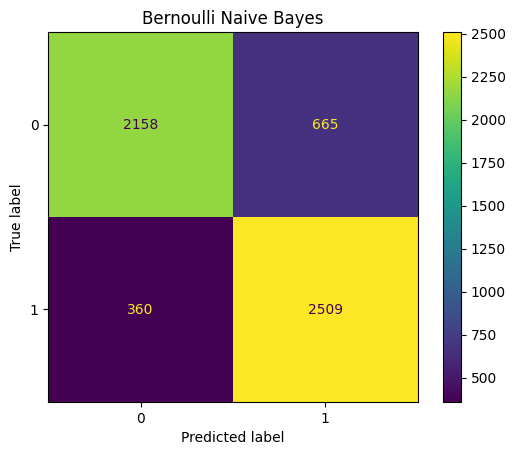

In [31]:
conf_matrix = confusion_matrix(y_test, y_preds)

conf_matrix_display = ConfusionMatrixDisplay(conf_matrix)

conf_matrix_display.plot()
if SAVE_MODEL:
  conf_matrix_display.figure_.savefig(f'{MODEL_FOLDER}/conf_matrix.png')

plt.title("Bernoulli Naive Bayes")
plt.show()

In [32]:
if SAVE_MODEL:
  joblib.dump(tfidf, f'{MODEL_FOLDER}/tfidf.pkl', compress=True)
  joblib.dump(bayes, f'{MODEL_FOLDER}/bayes.pkl', compress=True)
  print(f"Saved model to {MODEL_FOLDER}/bayes.pkl")